# 10-2. 머신러닝 프로젝트

## Airbnb(New York City)

* 미국 NYC Airbnb 목록(2019)
* 프로젝트 목적: 가격 예측(price)
* 제공 데이터(3개): train.csv, test.csv, y_test(최종 채점용)
* 평가 방식: MSE (평균제곱오차/ 실제 값과 예측 값 차이 ->제곱해 평균)
* <참고> : 6. 지도학습(회귀) 노드의 6-8. 평가(회귀) 스텝에서 복습하실 수 있습니다.
* 데이터 출처 바로가기 / License CC0: Public Domain
https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data?resource=download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Baseline

In [ ]:
# 라이브러리
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# 데이터 불러오기
#train = pd.read_csv('/aiffel/data/train.csv')
#test = pd.read_csv('/aiffel/data/test.csv')


# CSV 파일 로드
data = pd.read_csv('/content/drive/MyDrive/data/AB_NYC_2019.csv')

# 데이터 분리 (여기서는 예시로 80%의 데이터를 트레인 데이터로, 20%의 데이터를 테스트 데이터로 설정)
train, test = train_test_split(data, test_size=0.2, random_state=42)

# 트레인 데이터와 테스트 데이터를 CSV 파일로 저장
train.to_csv('/content/drive/MyDrive/data/train_NYC.csv', index=False)
test.to_csv('/content/drive/MyDrive/data/test_NYC.csv', index=False)



## 2. EDA(탐색적 데이터 분석)

탐색적으로 데이터 살펴보기

In [ ]:
# 데이터 크기
train.shape, test.shape

((39116, 16), (9779, 16))

In [ ]:
# 데이터 샘플
display(train.head(2))
display(test.head(2))

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
32645,25674366,Mid Century Modern Williamsburg Condo,9038810,Sanjay,Brooklyn,Williamsburg,40.71577,-73.95530,Entire home/apt,295,3,11,2019-05-16,0.87,1,1
23615,19100971,Spacious Bedroom with lots of Natural Light,81745867,Jacqueline,Manhattan,Washington Heights,40.84917,-73.94048,Private room,70,2,2,2018-06-25,0.16,1,0


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
879,317905,Come and go as you please in BKLN!,1631733,Jane,Brooklyn,Kensington,40.64354,-73.97777,Entire home/apt,89,3,62,2019-01-02,0.71,1,189
44383,34205267,"Spacious, sunny room in Queens/Brooklyn",913940,Giancarlo,Queens,Ridgewood,40.70666,-73.90779,Private room,30,21,0,NaN,NaN,1,73


In [ ]:
# 데이터 타입
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39116 entries, 32645 to 15795
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39116 non-null  int64  
 1   name                            39107 non-null  object 
 2   host_id                         39116 non-null  int64  
 3   host_name                       39098 non-null  object 
 4   neighbourhood_group             39116 non-null  object 
 5   neighbourhood                   39116 non-null  object 
 6   latitude                        39116 non-null  float64
 7   longitude                       39116 non-null  float64
 8   room_type                       39116 non-null  object 
 9   price                           39116 non-null  int64  
 10  minimum_nights                  39116 non-null  int64  
 11  number_of_reviews               39116 non-null  int64  
 12  last_review                 

In [ ]:
# 결측치(train)
train.isnull().sum()

id                                   0
name                                 9
host_id                              0
host_name                           18
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       8106
reviews_per_month                 8106
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [ ]:
# 결측치(test)
test.isnull().sum()

id                                   0
name                                 7
host_id                              0
host_name                            3
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1946
reviews_per_month                 1946
calculated_host_listings_count       0
availability_365                     0
dtype: int64

<Axes: >

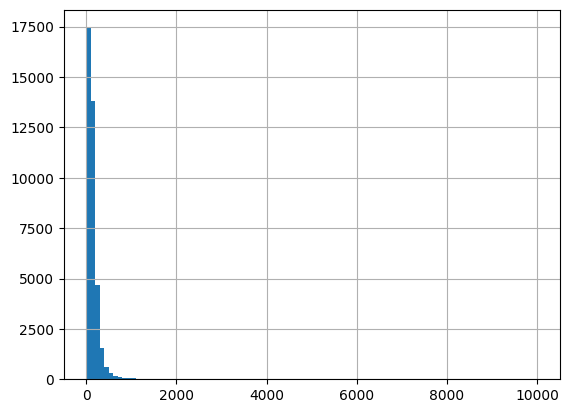

In [ ]:
# target(hist)
train['price'].hist(bins=100)

In [ ]:
# target(describe)
train['price'].describe()

count    39116.000000
mean       153.751585
std        247.037941
min          0.000000
25%         69.000000
50%        107.000000
75%        175.250000
max      10000.000000
Name: price, dtype: float64

In [ ]:
# 피처(host_id)
train['host_id'].value_counts()

219517861    265
107434423    192
30283594      91
137358866     79
16098958      77
            ... 
47718147       1
17470984       1
118727691      1
5944004        1
1722054        1
Name: host_id, Length: 30842, dtype: int64

## 3. 데이터 전처리

데이터를 살펴보고 판단하여 결측치 및 이상치를 처리

In [ ]:
# 결측치 컬럼 삭제(last_review)
# [[YOUR CODE]]

In [ ]:
# 결측치 채우기
# [[YOUR CODE]]

In [ ]:
# 결측치 확인
# [[YOUR CODE]]

In [ ]:
# 가격 값 복사
# [[YOUR CODE]]

In [ ]:
# 가격 값 복사
# [[YOUR CODE]]

##  4. 검증 데이터 분리

Train 데이터로 학습(훈련), Validation(검증용) 데이터로 예측

In [ ]:
# 검증 데이터 분리
# [[YOUR CODE]]

## 5. 머신러닝

<참고> : 6. 지도학습(회귀) 노드에서 프로젝트에 활용된 회귀 모델을 복습하실 수 있습니다.

In [ ]:
# 머신러닝(회귀)
# [[YOUR CODE]]

In [ ]:
# 릿지 회귀
# [[YOUR CODE]]

In [ ]:
# 라쏘 회귀
# [[YOUR CODE]]

In [ ]:
# 엘라스틱넷 회귀
# [[YOUR CODE]]

In [ ]:
# 랜덤포레스트
# [[YOUR CODE]]

In [ ]:
# Xgboost
# [[YOUR CODE]]

## 6. 채점

In [ ]:
# test 데이터 예측 및 평가
y_test = pd.read_csv('/content/drive/MyDrive/data/test_NYC.csv')

In [ ]:
# Xgboost
pred = model.predict(test)
mean_squared_error(y_test, pred)

NameError: name 'model' is not defined

In [ ]:
# baseline score(mse 51xxx) 보다 점수가 낮게 나오도록 도전해 보세요!
print("나의 점수는 (MSE #[[YOURE CODE]])입니다.")

## 7. 성능향상 Tip

baseline score보다 점수가 낮게 나오도록 프로젝트를 도전해 보셨나요?
성능 향상을 위한 TIP코드를 준비했으니 아래 준비한 파일을 다운 받아 LMS에 직접 입력하거나 코랩, 주피터 노트북 등에서 활용해 보세요.
(아래 링크를 우클릭해서 다운받아보세요!)



## 정리

1. 데이터 전처리

수치형 피처는 스케일링, 범주형 피처는 인코딩 전처리를 할 수 있습니다.
2. 데이터

Train 데이터로 학습(훈련)하고, Validation(검증용) 데이터로 예측/평가 후, 최종적으로는 Test(평가) 데이터를 예측합니다.
3. 하이퍼 파라미터 튜닝

모델 성능 향상을 위해 하이퍼 파라미터 튜닝할 수 있습니다.
머신러닝 과정이 끝났습니다. 아쉬운 분들을 위해서 부록편 하나를 남겨 두었습니다.
항상 여러분의 열정을 응원하겠습니다. 감사합니다.

## 부록-이미지 데이터 만들고 분류하기

In [ ]:
# 라이브러리
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt

In [27]:
# 압축 해제
import shutil
shutil.unpack_archive("/content/drive/MyDrive/data/data.zip", "")

In [28]:
# 경로
train_path = "train/"
valid_path = "validation/"
print(train_path)
print(valid_path)

train/
validation/


In [29]:
# 이미지 데이터 제너레이터
# [[YOUR CODE]]

In [30]:
# flow_from_directory 함수로 폴더에서 이미지 가져옴
# [[YOUR CODE]]

In [31]:
# 샘플 이미지 출력
class_labels = ['good','bad']
batch = next(train_gen)
images, labels = batch[0], batch[1]

NameError: name 'train_gen' is not defined

In [ ]:

plt.figure(figsize=(12, 5))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(int)])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [32]:
# 모델
# [[YOUR CODE]]

In [ ]:
# 모델 컴파일
# [[YOUR CODE]]

In [ ]:

# 모델 훈련
# [[YOUR CODE]]

In [ ]:
# 학습 정확도
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
# loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()